Step 1: the image classes are in two sepaarate folders. we need to merge in one folder

In [46]:
import os
import random
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np

In [47]:
normal_folder = 'data/Normal/'
diseased_folder = 'data/Sick/'

# Get a list of file names in each folder
normal = [os.path.join(normal_folder, file) for file in os.listdir(normal_folder)]
diseased = [os.path.join(diseased_folder, file) for file in os.listdir(diseased_folder)]

# Combine data and labels
all_files = normal + diseased
random.shuffle(all_files)
labels=[]
class_folders=[normal_folder,diseased_folder]
for img_loc in all_files:
    for class_idx, class_folder in enumerate(class_folders):
            if class_folder in img_loc:
                labels.append(class_idx)
                break

In [48]:
print(all_files[:10])
print(labels[:10])

['data/Normal/N14.jpg', 'data/Normal/N1.jpg', 'data/Sick/C22.jpg', 'data/Sick/C25.jpg', 'data/Sick/C27.jpg', 'data/Normal/N21.jpg', 'data/Sick/C6.jpg', 'data/Normal/N29.jpg', 'data/Normal/N27.jpg', 'data/Normal/N12.jpg']
[0, 0, 1, 1, 1, 0, 1, 0, 0, 0]


In [49]:
# creating a dataframe using the two list
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64
data = {'file_name': [os.path.basename(path) for path in all_files],
        'label': labels,
        'path': all_files}
df=pd.DataFrame(data)

In [50]:
df.tail(10)

,file_name,label,path
50,C16.jpg,1,data/Sick/C16.jpg
51,C19.jpg,1,data/Sick/C19.jpg
52,N15.jpg,0,data/Normal/N15.jpg
53,N16.jpg,0,data/Normal/N16.jpg
54,C5.jpg,1,data/Sick/C5.jpg
55,N4.jpg,0,data/Normal/N4.jpg
56,N9.jpg,0,data/Normal/N9.jpg
57,N3.jpg,0,data/Normal/N3.jpg
58,N11.jpg,0,data/Normal/N11.jpg
59,C9.jpg,1,data/Sick/C9.jpg


randomly visulaising some of images from dataframe

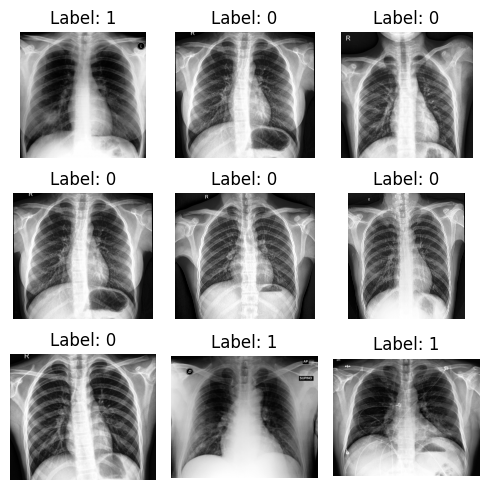

In [51]:

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for row in axes:
    for ax in row:
        idx = random.randint(0, len(df) - 1)
        img = Image.open(df.loc[idx, 'path'])
        ax.imshow(img)
        ax.set_title(f"Label: {df.loc[idx, 'label']}")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [52]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df,test_size=0.6,random_state=42)

In [53]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(48, 3)
(8, 3)
(4, 3)


In [54]:
# device configuration
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")

**Data transformation**
- resize,normalize methods to all sets(train,test)
- augmentation technique is applied to only train set

In [55]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(p=.05),
    transforms.RandomVerticalFlip(p=.05),
    transforms.RandomRotation(degrees=20), 
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2)),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Add random affine
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


# transform whole dataset for visualization purpose
data_transform = transforms.Compose([
    transforms.Resize(size=(224)),
    transforms.ToTensor(),
])

In [56]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 2]  # Index 2 corresponds to 'file path' column
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])  # Index 1 corresponds to 'label' column
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [57]:
# create dataset and data loaders
train_dataset = CustomDataset(train_df, transform=train_transform)
val_dataset=CustomDataset(val_df,transform=val_transform)
test_dataset = CustomDataset(test_df, transform=test_transform)
whole_dataset = CustomDataset(df, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=0,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=16,num_workers=0,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0,shuffle=False)
whole_loader = DataLoader(df, batch_size=16, shuffle=False)

after transformation let's have a look on the train datasets


In [58]:
#get some random data from training set and let's see
dataiter=iter(train_loader)
images,labels=next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


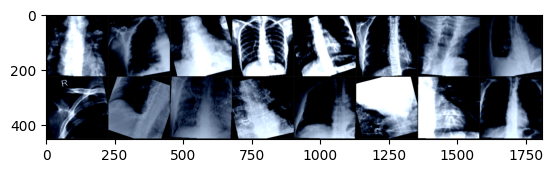

In [59]:
#plotting some data
def imshow(img):
    img=img/2+.05  #unnormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

In [60]:
print(images.shape)

torch.Size([16, 3, 224, 224])


In [61]:
num_epochs=10
learning_rate=1e-4
batch_size=16
wt_decay=1e-4
load_data=True



Before using transfer learning, I want to define my own CNN model and evaluate it.

In [62]:
# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 2)  # Binary classification

# model_vgg18 = models.resnet18(pretrained=True)
# model_vgg18.fc = nn.Linear(in_features=512, out_features=2)
# model_vgg18= model_vgg18.to(device)

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)
optimizer= torch.optim.SGD(vgg16.parameters(),lr=0.001,weight_decay=wt_decay)

In [64]:
# Train the model
num_epochs = 10  # Example: 10 epochs
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [65]:
# Function to save a checkpoint
def save_checkpoint(state, filename='checkpoints/vgg16/checkpoint.pth'):
    torch.save(state, filename)
# Function to load a checkpoint
def load_checkpoint(model, optimizer, filename='checkpoints/vgg16/checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer


In [69]:
best_loss = float('inf')
patience = 3  # Number of epochs without improvement to wait before early stopping
counter = 0
for epoch in range(num_epochs):
    vgg16.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Validation
    vgg16.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = vgg16(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        checkpoint = {'state_dict': vgg16.state_dict(), 'optimizer': optimizer.state_dict()}
        save_checkpoint(checkpoint, filename=f'checkpoints/vgg16/best_checkpoint.pth')
        
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break
print('Finished Training')

Epoch [1/10], Loss: 0.6479, Validation Loss: 0.4299
Epoch [2/10], Loss: 0.4632, Validation Loss: 0.4102
Epoch [3/10], Loss: 0.5990, Validation Loss: 0.3851
Epoch [4/10], Loss: 0.5322, Validation Loss: 0.3724
Epoch [5/10], Loss: 0.4259, Validation Loss: 0.3306
Epoch [6/10], Loss: 0.6433, Validation Loss: 0.3152
Epoch [7/10], Loss: 0.4833, Validation Loss: 0.2880
Epoch [8/10], Loss: 0.2332, Validation Loss: 0.2621
Epoch [9/10], Loss: 0.5071, Validation Loss: 0.2388
Epoch [10/10], Loss: 0.3610, Validation Loss: 0.2287
Finished Training


In [75]:

# Load the best checkpoint and test the model
load_model = True
if load_model:
    best_model = models.vgg16(pretrained=True).to(device)
    best_model.classifier[6] = nn.Linear(4096, 2)  # Modify the classifier for your specific task
    best_optimizer = torch.optim.SGD(best_model.parameters(), lr=learning_rate, weight_decay=wt_decay)
    best_model, best_optimizer = load_checkpoint(best_model, best_optimizer, filename='checkpoints/vgg16/best_checkpoint.pth')

    best_model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    #training loss and training accuracy
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = best_model(images)
            train_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {accuracy:.3%}')


Training Loss: 0.3557, Training Accuracy: 87.500%


In [77]:

# Load the best checkpoint and test the model
load_model = True
if load_model:
    best_model = models.vgg16(pretrained=True).to(device)
    best_model.classifier[6] = nn.Linear(4096, 2)  # Modify the classifier for your specific task
    best_optimizer = torch.optim.SGD(best_model.parameters(), lr=learning_rate, weight_decay=wt_decay)
    best_model, best_optimizer = load_checkpoint(best_model, best_optimizer, filename='checkpoints/vgg16/best_checkpoint.pth')

    best_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    #training loss and training accuracy
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = best_model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / total
    print(f'Training Loss: {test_loss:.4f}, Training Accuracy: {accuracy:.3%}')

Training Loss: 0.3094, Training Accuracy: 87.500%
